# Model Demo

In [3]:
import numpy as np
import torch
from torch.backends import cudnn
import cv2
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())

Tesla K80


### Utility Functions
Functions to transform, get mask predictions and apply masks on the input images.<br />
<hr>

In [24]:
def infer_op(op):
    '''Convert output to cpu tensor then to numpy array and scale up range from [0.0 to 1.0] to [0 to 255]'''
    op = op['out'].cpu().detach().numpy()
    op = op * 255
    op.astype(np.uint8)

    return op

def apply_mask(img, mask):
    '''Apply generated mask on image'''
    assert np.shape(mask) == (224, 224)

    img = cv2.resize(img, (224, 224))
    portrait = cv2.bitwise_and(img, img, mask = mask)

    return portrait

In [13]:
def get_mask(img, model):
    '''Transform input image to make compatible with model and return mask image'''
    #CUDA for PyTorch
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")
    cudnn.benchmark = True

    model.to(device)
    model.eval()

    tf = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=True),
        torchvision.transforms.Lambda(lambda x: torch.reshape(x, (-1, x.size()[0], x.size()[1], x.size()[2])))
    ])
    img = tf(img).to(device)

    mask = model(img)

    return infer_op(mask)

<hr>

## Applying Model
Apply model on custom image.<br /> `img_path` refers to location of image.

In [14]:
img_path = './sample_img.jpg'

Load pretrained model

In [9]:
model = torch.load('../models/deeplab.pt')

### Input Image

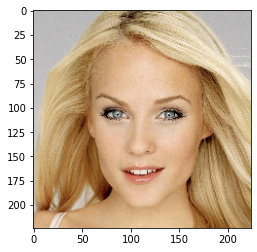

In [15]:
img = Image.open(img_path)
plt.imshow(img)

Resizing image to 224x224 to make it compatible with model input.

In [16]:
inp_size = (224, 224)
img = img.resize(inp_size)
img = np.asarray(img)

### Generated Mask

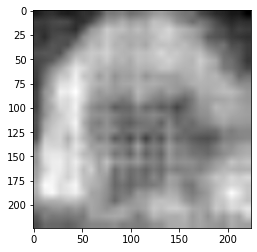

In [35]:
mask = get_mask(img, model)
mask = np.reshape(mask, (224, 224))
plt.imshow(mask, 'gray')

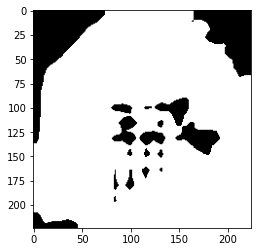

In [32]:
_, thresh1 = cv2.threshold(mask,175,255,cv2.THRESH_BINARY)
plt.imshow(thresh1, 'gray')